# Internet Patters

### Data Preperation

Firstly load additional datasets from [world bank](https://data.worldbank.org/), which are related to education and economic indicators.
Also there is other useful internet metrics, like speed of the internet.

Additionally, we will load data for abbreviated country names, internet speed, GDP, and education level. The data is structured so that each year corresponds to its own column. For convenience, we will transform the GDP and EDU tables using pivot. When importing an Excel table, there are empty rows at the end that interfere with further code writing. To fix this, we will take only those rows that contain information.

```
python 
edu_stat = edu_stat.iloc[:816,[0,1,2,4,5,6,7,8]]
gdp_stat = gdp_stat.iloc[:798,[0,1,2,4,5,6,7,8]]
```


In [49]:
patterns_df = pd.read_csv('data/internet_usage.csv') # load main table
patterns_df = patterns_df.replace("..", np.nan)

country_reg = pd.read_excel('data/country_regions.xlsx') # add abbreviations in country names
patterns_df = patterns_df.merge(country_reg, how = 'left', left_on = 'Country Name', right_on = 'Country')
patterns_df = patterns_df.drop('Country', axis=1)

internet_speed = pd.read_csv('data/internet_speed.csv') # additional information about internet speed
internet_speed.rename(columns={'Region': 'Region_int'}, inplace=True)
patterns_df = patterns_df.merge(internet_speed, how = 'left', left_on = 'Country Name', right_on = 'Region_int')
patterns_df = patterns_df.iloc[:,[0,1,26,27,29,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]


edu_stat = pd.read_csv('data/edu.csv', na_values=['..']) # read education data
edu_stat = edu_stat.iloc[:816,[0,1,2,4,5,6,7,8]]

edu_stat = edu_stat.melt(id_vars = ['Country Name', 'Country Code','Series']) # data transformation for convenient work with tables
edu_stat['variable'] = edu_stat['variable'].astype(str).str[:4]
edu_stat['variable'] = pd.to_numeric(edu_stat["variable"])
edu_stat = edu_stat.rename(columns = {'variable':'year'})
edu_stat = edu_stat.pivot(index=['Country Name','Country Code','year'],columns='Series', values='value')

gdp_stat = pd.read_csv('data/GDP.csv', na_values=['..']) # read GDP stats
gdp_stat = gdp_stat.iloc[:798,[0,1,2,4,5,6,7,8]]

def normolize_gdp (row): #  number transformation for readability
    if (row['Series Name'] == 'GDP (current US$)'):
        row['2000 [YR2000]'] = row['2000 [YR2000]']/1000000
        row['2005 [YR2005]'] = row['2005 [YR2005]'] / 1000000
        row['2010 [YR2010]'] = row['2010 [YR2010]'] / 1000000
        row['2015 [YR2015]'] = row['2015 [YR2015]'] / 1000000
        row['2020 [YR2020]'] = row['2020 [YR2020]'] / 1000000
    return row
gdp_stat = gdp_stat.apply(normolize_gdp, axis='columns')

gdp_stat = gdp_stat.melt(id_vars = ['Country Name', 'Country Code','Series Name']) # data transformation for convenient work with tables
gdp_stat['variable'] = gdp_stat['variable'].astype(str).str[:4]
gdp_stat['variable'] = pd.to_numeric(gdp_stat["variable"])
gdp_stat = gdp_stat.rename(columns = {'variable':'year'})
gdp_stat = gdp_stat.pivot(index=['Country Name','Country Code','year'],columns='Series Name', values='value')


### EDA & Analisys
Let's look at the trend of Internet usage in different regions.

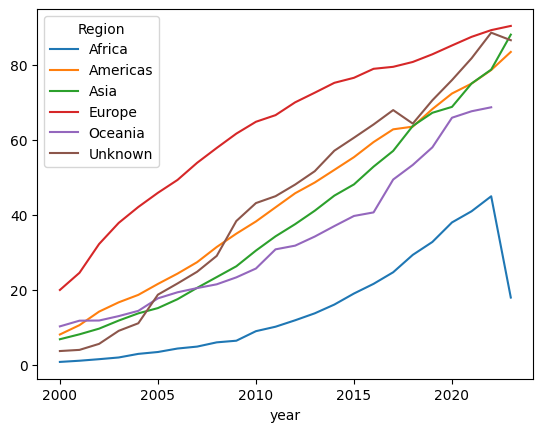

In [50]:
########################################################### EDA & Analisys

patterns_melted_df = patterns_df.melt(id_vars = ['Country Name', 'Country Code','Region','Ranking','Broadband Internet Speed 2023'])
patterns_melted_df['value'] = patterns_melted_df['value'].astype(float)
patterns_melted_df = patterns_melted_df.rename(columns = {'variable':'year'})
patterns_melted_df.pivot_table(index='year',columns='Region',values='value',aggfunc='mean').plot(kind='line')
plt.show()

Let`s discover distribution 2000 and 2022 (size in prct groups of int usage)

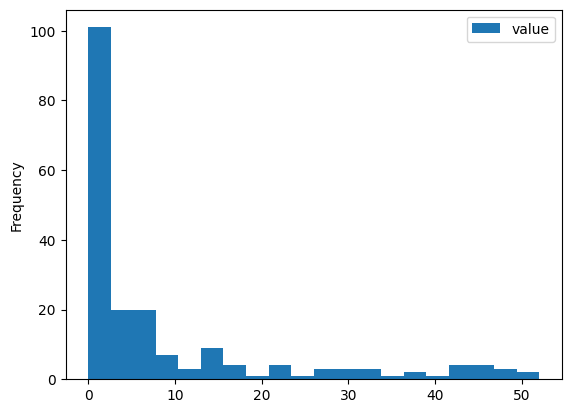

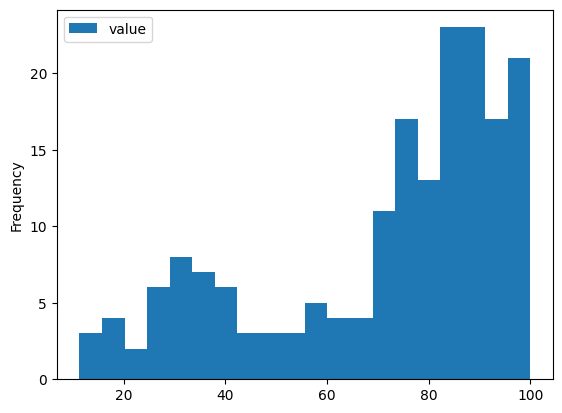

In [51]:
# discover distribution 2000 and 2022
usage_by_country_2000 = patterns_melted_df[patterns_melted_df['year'] == "2000"].groupby('Country Name')['value'].mean().reset_index()
usage_by_country_2000.plot(kind = "hist", bins = 20)
plt.show()
usage_by_country_2020 = patterns_melted_df[patterns_melted_df['year'] == "2022"].groupby('Country Name')['value'].mean().reset_index()
usage_by_country_2020.plot(kind = "hist", bins = 20)
plt.show()

We can see a clear advantage in terms of internet accessibility, reaching up to 100%. However, there are still groups of countries where accessibility is only 30-40%.

Let's take a closer look at the development of the Internet in developed countries and countries that are just beginning to grow.
First, I will calculate the quantiles.

In [52]:
quantile_zerozerofive = usage_by_country_2000['value'].quantile(q=0.05)
quantile_zeroninefive = usage_by_country_2000['value'].quantile(q=0.95)


Next, I will create lists of countries that are among the worst 5% (the algorithm is similar for the top 95%). 

In [53]:
under_zerozerofive = usage_by_country_2000[
    usage_by_country_2000['value'].notna() &
    (usage_by_country_2000['value'] <= quantile_zerozerofive)
].sort_values('value', ascending=True)
higher_zeroninefive = usage_by_country_2000[
    usage_by_country_2000['value'].notna() &
    (usage_by_country_2000['value'] >= quantile_zeroninefive)
].sort_values('value', ascending=True)
under_zerozerofive_list = under_zerozerofive['Country Name'].to_list()
higher_zeroninefive_list = higher_zeroninefive['Country Name'].to_list()


At the end, I visualize the data.

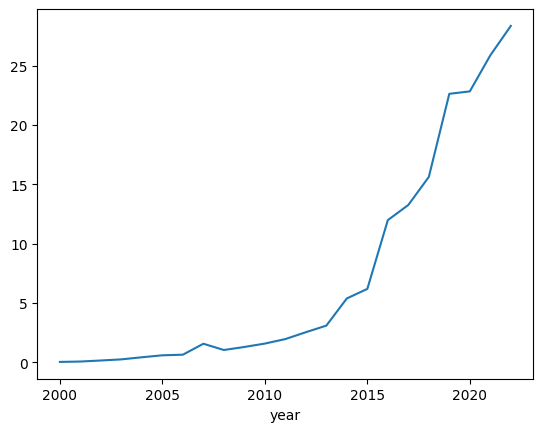

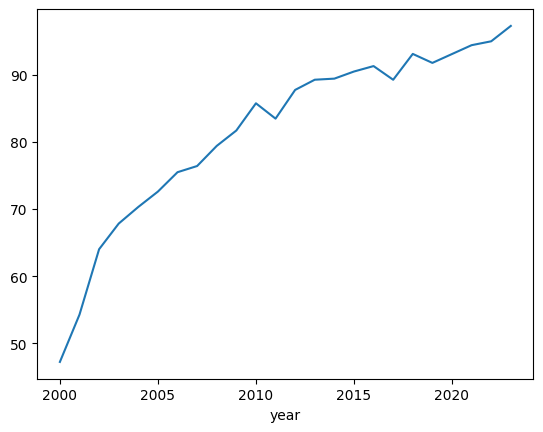

In [54]:
plt.close('all')

under_zerozerofive_trend = patterns_melted_df[patterns_melted_df['Country Name'].isin(under_zerozerofive_list)].groupby('year')['value'].mean()
under_zerozerofive_trend.plot(kind='line')
plt.show()

higher_zeroninefive_trend = patterns_melted_df[patterns_melted_df['Country Name'].isin(higher_zeroninefive_list)].groupby('year')['value'].mean()
higher_zeroninefive_trend.plot(kind='line')
plt.show()

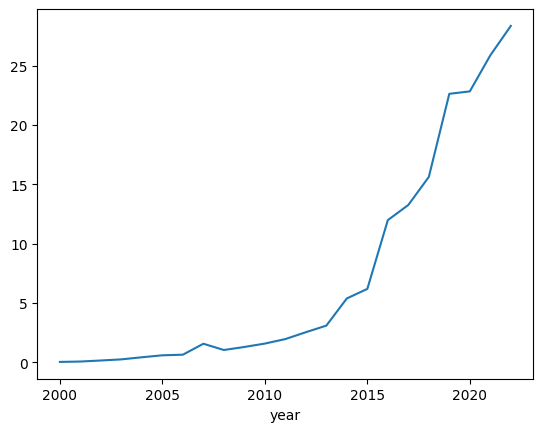

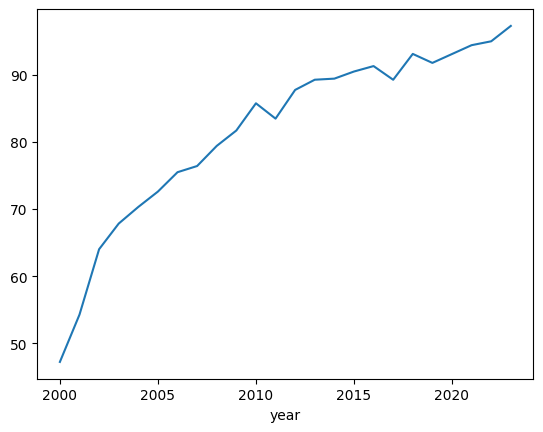

In [55]:
quantile_zerozerofive = usage_by_country_2000['value'].quantile(q=0.05)
quantile_zeroninefive = usage_by_country_2000['value'].quantile(q=0.95)

under_zerozerofive = usage_by_country_2000[
    usage_by_country_2000['value'].notna() &
    (usage_by_country_2000['value'] <= quantile_zerozerofive)
].sort_values('value', ascending=True)
higher_zeroninefive = usage_by_country_2000[
    usage_by_country_2000['value'].notna() &
    (usage_by_country_2000['value'] >= quantile_zeroninefive)
].sort_values('value', ascending=True)
under_zerozerofive_list = under_zerozerofive['Country Name'].to_list()
higher_zeroninefive_list = higher_zeroninefive['Country Name'].to_list()

plt.close('all')

under_zerozerofive_trend = patterns_melted_df[patterns_melted_df['Country Name'].isin(under_zerozerofive_list)].groupby('year')['value'].mean()
under_zerozerofive_trend.plot(kind='line')
plt.show()

higher_zeroninefive_trend = patterns_melted_df[patterns_melted_df['Country Name'].isin(higher_zeroninefive_list)].groupby('year')['value'].mean()
higher_zeroninefive_trend.plot(kind='line')
plt.show()

We can see steady growth, similar to logarithmic growth, in countries with good internet access.

Next, I created an apply method to check whether the country had achieved its goal, where the goal was to provide internet access to more than 50% of the population.

In [56]:
def isGoalAchived (row):  # check each country for achieving the goal
    if (row['value'] >= 50 ):
        row['isGoalAchived'] = 1
    else :
        row['isGoalAchived'] = 0
    return row
patterns_melted_df = patterns_melted_df.apply(isGoalAchived, axis ='columns')

If there is missing data for the following year, the average of the two neighboring years is taken, since the number of countries that have achieved the target cannot fall a priori. 

In [57]:
year_goal = patterns_melted_df.groupby('year')['isGoalAchived'].sum().reset_index() #transform table

year_goal['prev'] = year_goal['isGoalAchived'].shift(1) # add helpful columns for comparison and completion
year_goal['next'] = year_goal['isGoalAchived'].shift(-1)
plt.close('all')
def correct_values(row):
    if row['isGoalAchived'] < row['prev'] :
        row['isGoalAchived'] = (row['prev'] + row['next']) / 2
    return row

Let's not forget about visualization either.

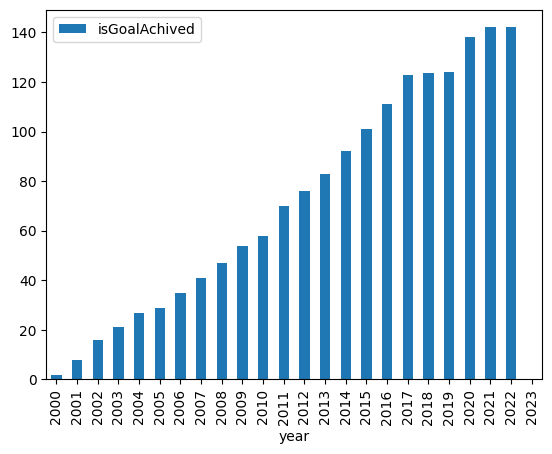

In [58]:
year_goal = year_goal.apply(correct_values, axis = 'columns')
year_goal.plot(kind = 'bar', x= 'year', y = 'isGoalAchived')
plt.show()

We can see steady growth, and that every year seven countries consistently meet their targets.

### Correlation Analysis

The most data-rich period for GDP is 2020, so I will try to find a correlation for that year. To do this, we filter the main table and the GDP table for 2020.

In [59]:
patterns_melted_2020_df = patterns_melted_df[patterns_melted_df['year'] == "2020"] #filter main table (2020)
patterns_melted_2020_df = patterns_melted_2020_df.reset_index()

gdp_stat = gdp_stat.reset_index() # add info about gdp in 2020
gdp_stat_2020 = gdp_stat[gdp_stat['year'] == 2020]


For the education sector, it is similar, except that a different year was chosen for the study, namely 2015.

In [60]:
patterns_melted_2015_df = patterns_melted_df[patterns_melted_df['year'] == "2015"] #filter main table (20125 year)
patterns_melted_2015_df = patterns_melted_2015_df.reset_index()

edu_stat = edu_stat.reset_index() # add info about gdp in 2015
edu_stat_2015 = edu_stat[edu_stat['year'] == 2015]

The following influencing factors were compared :
-GDP (current US$)
-Life expectancy at birth, total (years)
-Government expenditure on education as % of GDP (%)
-Adult literacy rate, population 15+ years, both sexes (%)
-Youth literacy rate, population 15-24 years, both sexes (%)
-Broadband Internet Speed 2023

This is an example of comparing one parameter with an Internet speed indicator.

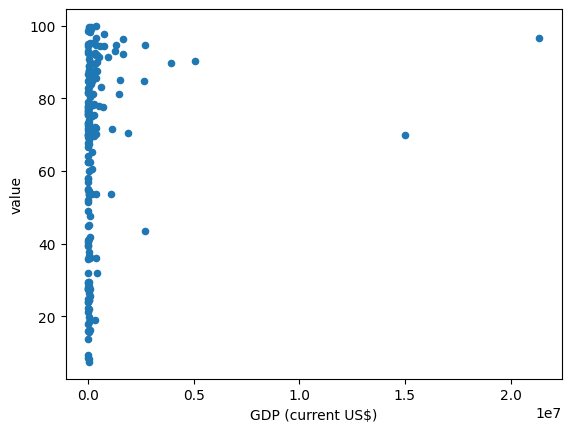

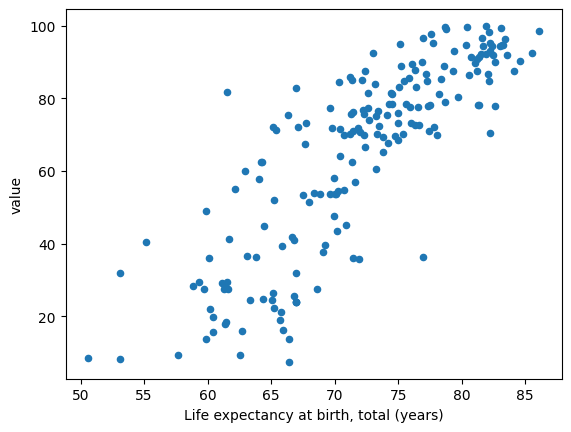

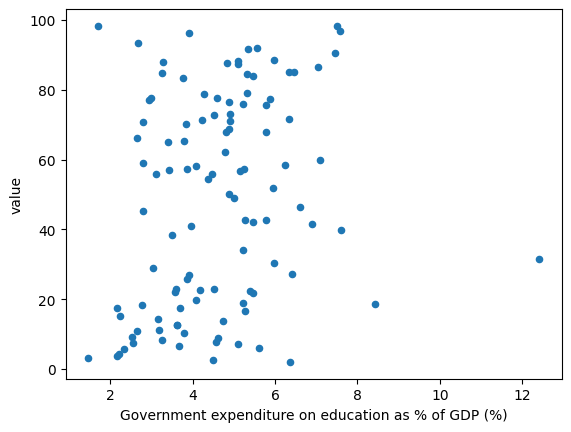

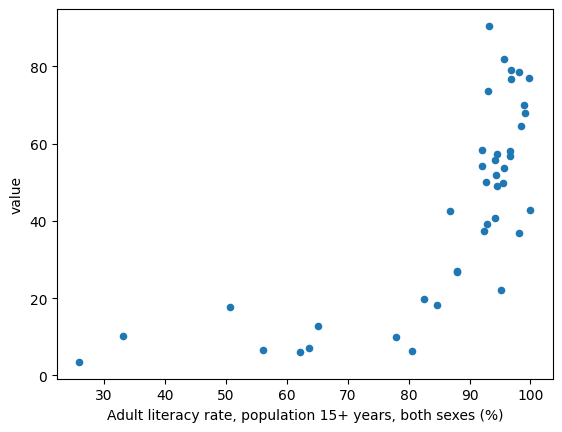

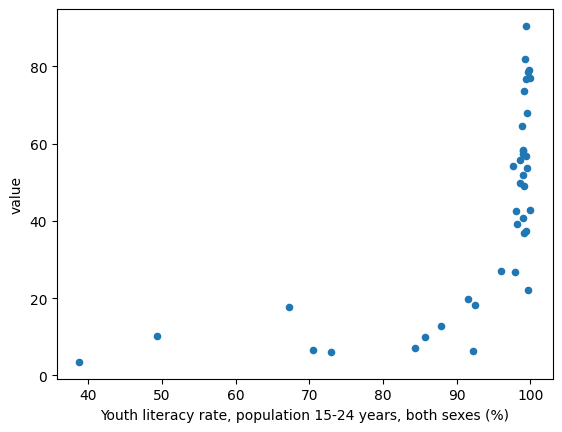

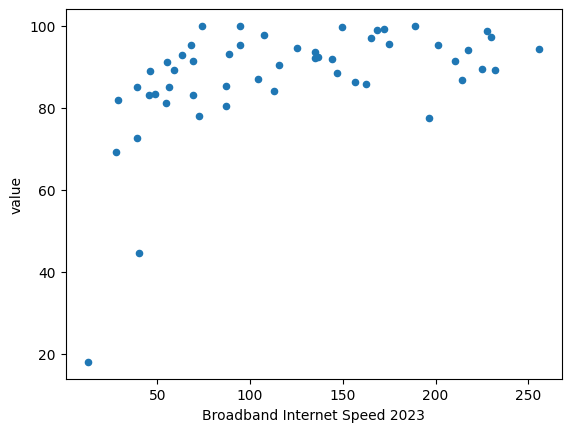

In [61]:
patterns_melted_2023_df = patterns_melted_df[patterns_melted_df['year'] == "2023"]
patterns_melted_2023_df = patterns_melted_2023_df.reset_index()


plt.close('all')
corr_gdp_2020 = patterns_melted_2020_df.merge(gdp_stat_2020, how = 'left', on = 'Country Name')
corr_gdp_2020.plot(kind = 'scatter', x = 'GDP (current US$)', y = 'value')
# plt.show()
corr_gdp_2020.plot(kind = 'scatter', x = 'Life expectancy at birth, total (years)', y = 'value')
plt.show()
corr_gdp_coeff = corr_gdp_2020[['value', 'GDP (current US$)', 'Life expectancy at birth, total (years)']]
corr_gdp_coeff = corr_gdp_coeff.corr(min_periods=3)
# print(corr_gdp_coeff)

corr_edu_2015 = patterns_melted_2015_df.merge(edu_stat_2015, how = 'left', on = 'Country Name')
corr_edu_2015.plot(kind = 'scatter', x = 'Government expenditure on education as % of GDP (%)', y = 'value')
# plt.show()
corr_edu_2015.plot(kind = 'scatter', x = 'Adult literacy rate, population 15+ years, both sexes (%)', y = 'value')
plt.show()
corr_edu_2015.plot(kind = 'scatter', x = 'Youth literacy rate, population 15-24 years, both sexes (%)', y = 'value')
plt.show()
corr_edu_coeff = corr_edu_2015[['value','Government expenditure on education as % of GDP (%)','Adult literacy rate, population 15+ years, both sexes (%)','Youth literacy rate, population 15-24 years, both sexes (%)']]
corr_edu_coeff = corr_edu_coeff.corr(min_periods=3)
# print(corr_edu_coeff)

patterns_melted_2023_df.plot(kind = 'scatter', x = 'Broadband Internet Speed 2023', y = 'value')
# plt.show()
corr_speed_coeff = patterns_melted_2023_df[['value','Broadband Internet Speed 2023']]
corr_speed_coeff = corr_speed_coeff.corr(min_periods=3)
# print(corr_speed_coeff)

The strongest connection was shown by : Life expectancy (0.83), Adult literacy rate (0.72), Youth literacy rate (0.64).
Surprisingly, internet speed did not show a strong correlation, only 0.47.

We can conclude that access to the internet generally has a positive effect on overall literacy levels (or at least can be considered an indicator).

### Regresion Analysis

First step : prepare columns for regresion models

In [62]:
reggression_table = patterns_melted_df[['Country Name', 'year', 'value']].copy()
reggression_table = reggression_table[reggression_table['Country Name'].isin(['Cambodia','Chad','Congo, Dem. Rep.','Congo, Rep.'])]
reggression_table = reggression_table.dropna()
reggression_table['year'] = reggression_table['year'].astype(int)
reggression_table['1/x'] = 1 / reggression_table['year']
reggression_table['1/y'] = 1 / reggression_table['value']
reggression_table['ln(X)'] = np.log(reggression_table['year'])
reggression_table['ln(Y)'] = np.log(reggression_table['value'])

For convenience, I will predict values for each country separately. To do this, I will break down the data frames by country.

In [63]:
reggression_table['predicted_value'] = np.nan # create empty col for predicted value
alredy_noticed_counrtries = [] # list so as not to repeat
list_of_dataframes = []

def create_unique_dataframes(row):
    country_name = row['Country Name']
    if country_name in alredy_noticed_counrtries:
        return
    else:
        list_of_dataframes.append(f'regression_table_{country_name}')
        globals()[f'regression_table_{country_name}'] = reggression_table[
            reggression_table['Country Name'] == country_name]
        alredy_noticed_counrtries.append(country_name)
        return

reggression_table.apply(create_unique_dataframes, axis=1)

33      None
38      None
44      None
45      None
251     None
        ... 
4623    None
4829    None
4834    None
4840    None
4841    None
Length: 89, dtype: object

The following formulas were used to generate the forecast values :

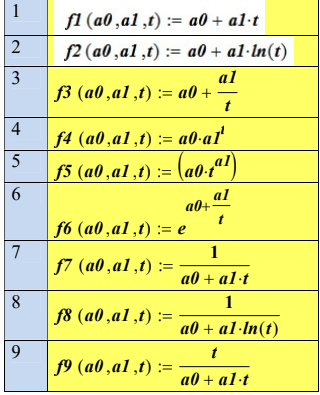

First, for each country that has more than two entries in the table, the slope and intercept coefficients are calculated for forecasting.

```
python

for name in list_of_dataframes:
    current_df = globals()[name].copy()

    current_df = current_df[current_df['value'] > 0.10].copy().reset_index(drop=True)

    if len(current_df) < 2:
        continue

    slope_1, intercept_1, _, _, _ = stats.linregress(current_df['year'], current_df['value'])
    slope_2, intercept_2, _, _, _ = stats.linregress(current_df['ln(X)'], current_df['value'])
    ...
```

For each year, the value is calculated for all 9 models.
```
python

model_sq = {i: [] for i in range(1, 10)}

    for idx, row in current_df.iterrows():
        x, y, ln_x, inv_x = row['year'], row['value'], row['ln(X)'], row['1/x']
        model_sq[1].append((y - (intercept_1 + slope_1 * x)) ** 2)
        model_sq[2].append((y - (intercept_2 + slope_2 * ln_x)) ** 2)
```

Next, the best model is selected based on the standard error. Before doing so, significant values are taken to avoid outliers. Without using this filtering, developing countries mistakenly choose a linear model even though it is not correct.
```
python
    current_df = current_df[current_df['value'] > 0.10].copy().reset_index(drop=True)
    model_sq = {i: [] for i in range(1, 10)}

        for idx, row in current_df.iterrows():
            x, y, ln_x, inv_x = row['year'], row['value'], row['ln(X)'], row['1/x']
            model_sq[1].append((y - (intercept_1 + slope_1 * x)) ** 2)
            model_sq[2].append((y - (intercept_2 + slope_2 * ln_x)) ** 2)
            ...
```

After that, the best model is selected and used to predict values.

```
python

errors_dict = {i: sum(model_sq[i]) for i in range(1, 10)}
    best_model_idx = min(errors_dict, key=errors_dict.get)
    if best_model_idx == 1:
        predictions = intercept_1 + slope_1 * current_df['year']
    elif best_model_idx == 2:
        predictions = intercept_2 + slope_2 * current_df['ln(X)']
    ...

    current_df['predicted_value'] = predictions
    current_df['predicted_value'] = current_df['predicted_value'].clip(upper=100)

    future_years = np.array([2024, 2025, 2026])
    f_ln_x = np.log(future_years)
    f_inv_x = 1 / future_years

    if best_model_idx == 1:
        f_preds = intercept_1 + slope_1 * future_years
    elif best_model_idx == 2:
        f_preds = intercept_2 + slope_2 * f_ln_x
    ...

    future_df['predicted_value'] = future_df['predicted_value'].clip(upper=100)
    reggression_table = pd.concat([reggression_table, current_df, future_df], ignore_index=True)
```
    

         Country Name  year  value  1/x  1/y  ln(X)  ln(Y)  predicted_value
110          Cambodia  2025    NaN  NaN  NaN    NaN    NaN        57.598899
134              Chad  2025    NaN  NaN  NaN    NaN    NaN        27.676433
157  Congo, Dem. Rep.  2025    NaN  NaN  NaN    NaN    NaN        84.892980
179       Congo, Rep.  2025    NaN  NaN  NaN    NaN    NaN        75.009224


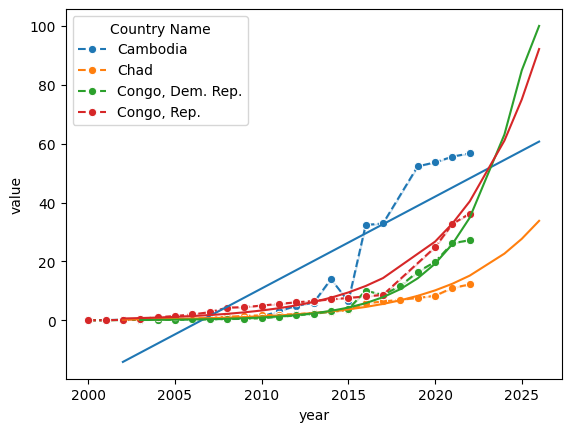

In [64]:
for name in list_of_dataframes:
    current_df = globals()[name].copy()

    current_df = current_df[current_df['value'] > 0.10].copy().reset_index(drop=True)

    if len(current_df) < 2:
        continue

    slope_1, intercept_1, _, _, _ = stats.linregress(current_df['year'], current_df['value'])
    slope_2, intercept_2, _, _, _ = stats.linregress(current_df['ln(X)'], current_df['value'])
    slope_3, intercept_3, _, _, _ = stats.linregress(current_df['1/x'], current_df['value'])
    slope_4, intercept_4, _, _, _ = stats.linregress(current_df['year'], current_df['ln(Y)'])
    slope_5, intercept_5, _, _, _ = stats.linregress(current_df['ln(X)'], current_df['ln(Y)'])
    slope_6, intercept_6, _, _, _ = stats.linregress(current_df['1/x'], current_df['ln(Y)'])
    slope_7, intercept_7, _, _, _ = stats.linregress(current_df['year'], current_df['1/y'])
    slope_8, intercept_8, _, _, _ = stats.linregress(current_df['ln(X)'], current_df['1/y'])
    slope_9, intercept_9, _, _, _ = stats.linregress(current_df['1/x'], current_df['1/y'])

    model_sq = {i: [] for i in range(1, 10)}

    for idx, row in current_df.iterrows():
        x, y, ln_x, inv_x = row['year'], row['value'], row['ln(X)'], row['1/x']
        model_sq[1].append((y - (intercept_1 + slope_1 * x)) ** 2)
        model_sq[2].append((y - (intercept_2 + slope_2 * ln_x)) ** 2)
        model_sq[3].append((y - (intercept_3 + slope_3 * inv_x)) ** 2)
        model_sq[4].append((y - np.exp(intercept_4 + slope_4 * x)) ** 2)
        model_sq[5].append((y - np.exp(intercept_5 + slope_5 * ln_x)) ** 2)
        model_sq[6].append((y - np.exp(intercept_6 + slope_6 * inv_x)) ** 2)
        model_sq[7].append((y - (1 / (intercept_7 + slope_7 * x))) ** 2)
        model_sq[8].append((y - (1 / (intercept_8 + slope_8 * ln_x))) ** 2)
        model_sq[9].append((y - (1 / (intercept_9 + slope_9 * inv_x))) ** 2)

    errors_dict = {i: sum(model_sq[i]) for i in range(1, 10)}
    best_model_idx = min(errors_dict, key=errors_dict.get)

    if best_model_idx == 1:
        predictions = intercept_1 + slope_1 * current_df['year']
    elif best_model_idx == 2:
        predictions = intercept_2 + slope_2 * current_df['ln(X)']
    elif best_model_idx == 3:
        predictions = intercept_3 + slope_3 * current_df['1/x']
    elif best_model_idx == 4:
        predictions = np.exp(intercept_4 + slope_4 * current_df['year'])
    elif best_model_idx == 5:
        predictions = np.exp(intercept_5 + slope_5 * current_df['ln(X)'])
    elif best_model_idx == 6:
        predictions = np.exp(intercept_6 + slope_6 * current_df['1/x'])
    elif best_model_idx == 7:
        predictions = 1 / (intercept_7 + slope_7 * current_df['year'])
    elif best_model_idx == 8:
        predictions = 1 / (intercept_8 + slope_8 * current_df['ln(X)'])
    elif best_model_idx == 9:
        predictions = 1 / (intercept_9 + slope_9 * current_df['1/x'])

    current_df['predicted_value'] = predictions
    current_df['predicted_value'] = current_df['predicted_value'].clip(upper=100)

    future_years = np.array([2024, 2025, 2026])
    f_ln_x = np.log(future_years)
    f_inv_x = 1 / future_years

    if best_model_idx == 1:
        f_preds = intercept_1 + slope_1 * future_years
    elif best_model_idx == 2:
        f_preds = intercept_2 + slope_2 * f_ln_x
    elif best_model_idx == 3:
        f_preds = intercept_3 + slope_3 * f_inv_x
    elif best_model_idx == 4:
        f_preds = np.exp(intercept_4 + slope_4 * future_years)
    elif best_model_idx == 5:
        f_preds = np.exp(intercept_5 + slope_5 * f_ln_x)
    elif best_model_idx == 6:
        f_preds = np.exp(intercept_6 + slope_6 * f_inv_x)
    elif best_model_idx == 7:
        f_preds = 1 / (intercept_7 + slope_7 * future_years)
    elif best_model_idx == 8:
        f_preds = 1 / (intercept_8 + slope_8 * f_ln_x)
    elif best_model_idx == 9:
        f_preds = 1 / (intercept_9 + slope_9 * f_inv_x)

    country_name = current_df['Country Name'].iloc[0]
    future_df = pd.DataFrame({
        'Country Name': [country_name] * 3,
        'year': future_years,
        'predicted_value': f_preds,
        'value': [np.nan] * 3
    })
    future_df['predicted_value'] = future_df['predicted_value'].clip(upper=100)

    reggression_table = pd.concat([reggression_table, current_df, future_df], ignore_index=True)

print(reggression_table[reggression_table['year']==2025])
plt.close('all')
sns.lineplot(data=reggression_table, x='year', y='value', hue='Country Name', marker='o', linestyle='--')
sns.lineplot(data=reggression_table, x='year', y='predicted_value', hue='Country Name', legend=False)
plt.show()

The model can be applied to one country or to all countries at once. A graph was provided for demonstration purposes. Solid lines without marks represent forecast functions. For clarity, the sample was limited to four countries.